Notebook showing usage of the data detective package.

**References**
* https://facebook.github.io/prophet/

In [1]:
# To import detective from relative folder
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import detective.core as detective
import detective.helpers as helpers
from fbprophet import Prophet
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # Suppress chained_assignment warning, default='warn'
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

To load from a local db, we just need the path

In [2]:
db_path = 'Users/robincole/Documents/Home-assistant_database/home-assistant_v2.db'
DB_URL = 'sqlite:////' + db_path

Alternatively, to load from a cloud database we load from a json file containing the url as the url contains our credentials and we want to lkeep these a secret. To learn how the Google CLoud SQL recorder can be setup checkout https://github.com/robmarkcole/HASS-Google-Cloud-SQL

In [3]:
# For cloud database with secret credentials, load from json. Time to load vaires, up to 3 mins.
filename = '/Users/robincole/Desktop/hass_db_url.json'
DB_URL = helpers.load_url(filename)

## Load the db data

We use the DataParser class to load data from the database. This class performs the SQL queries and parses the returned data. The class holds the master pandas dataframe master_df.

In [4]:
%%time
parser = detective.DataParser(DB_URL)

Querying the database, this could take a while
CPU times: user 6.23 s, sys: 1.29 s, total: 7.51 s
Wall time: 1min 2s


Lets create an object holding the numerical sensor

In [5]:
sensors_num = detective.NumericalSensors(parser.master_df)

We can access the list of sensor entities using the list_sensors attribute

In [6]:
sensors_num.entities[0:10]

['sensor.bme680humidity',
 'sensor.bme680pressure',
 'sensor.next_train_in',
 'sensor.living_room_temperature',
 'sensor.darksky_sensor_temperature',
 'sensor.mean_temperature',
 'sensor.bme680temperature',
 'sensor.bedroom_temperature',
 'sensor.next_train_to_wim',
 'sensor.network_up']

Now lets look at the dataframe

In [7]:
sensors_num.data.head()

entity,sensor.bayes_probability,sensor.bedroom_temperature,sensor.blink_blink_camera_percy_notifications,sensor.blink_blink_camera_percy_temperature,sensor.bme680air_qual,sensor.bme680humidity,sensor.bme680pressure,sensor.bme680temperature,sensor.cpu_load_total,sensor.darksky_sensor_precip_probability,...,sensor.network_up,sensor.next_train_in,sensor.next_train_to_wim,sensor.robins_iphone_battery_level,sensor.speedtest_download,sensor.time_in_bed,sensor.volume_used_volume_1,sensor.wemo_current_power_w,sensor.wemo_today_energy_kwh,sensor.work_to_home
last_changed,,,,,,,,,,,,,,,,,,,,,
2018-02-03 20:54:21.303548,0.03,17.77,1.0,18.0,7549489.0,45.957,1016.85,22.07,51.0,98.0,...,4.6,20.0,20.0,100.0,73.86,7.05,19.7,1.88,0.16,26.0
2018-02-03 20:54:21.307471,0.03,17.77,1.0,18.0,7549489.0,45.957,1016.85,22.07,51.0,98.0,...,4.6,20.0,20.0,100.0,73.86,7.05,19.7,1.88,0.16,26.0
2018-02-03 20:54:21.313233,0.03,17.77,1.0,18.0,7549489.0,45.957,1016.85,22.07,51.0,98.0,...,4.6,20.0,20.0,100.0,73.86,7.05,19.7,1.88,0.16,26.0
2018-02-03 20:54:21.316310,0.03,17.77,1.0,18.0,7549489.0,45.957,1016.85,22.07,51.0,98.0,...,4.6,20.0,20.0,100.0,73.86,7.05,19.7,1.88,0.16,26.0
2018-02-03 20:54:21.374422,0.03,17.77,1.0,18.0,7549489.0,45.957,1016.85,22.07,51.0,98.0,...,4.6,20.0,20.0,100.0,73.86,7.05,19.7,1.88,0.16,26.0


In [8]:
sensors_num.data.index

DatetimeIndex(['2018-02-03 20:54:21.303548', '2018-02-03 20:54:21.307471',
               '2018-02-03 20:54:21.313233', '2018-02-03 20:54:21.316310',
               '2018-02-03 20:54:21.374422', '2018-02-03 20:54:21.405760',
               '2018-02-03 20:54:21.904894', '2018-02-03 20:54:22.117675',
               '2018-02-03 20:54:22.121273', '2018-02-03 20:54:25.167167',
               ...
               '2018-02-04 16:46:20.455960', '2018-02-04 16:46:20.465710',
               '2018-02-04 16:46:35.943171', '2018-02-04 16:46:45.892644',
               '2018-02-04 16:47:06.924151', '2018-02-04 16:47:37.910008',
               '2018-02-04 16:47:53.361806', '2018-02-04 16:47:53.370722',
               '2018-02-04 16:48:08.909861', '2018-02-04 16:48:39.921245'],
              dtype='datetime64[ns]', name='last_changed', length=5168, freq=None)

Lets now check for correlations in the data using the all_corrs() method

In [9]:
corrs = sensors_num.correlations()

In [10]:
corrs[(corrs['value'] > 0.5) | (corrs['value'] < -0.5)]

,value
sensor.next_train_to_wim-sensor.next_train_in,0.992208
sensor.wemo_today_energy_kwh-sensor.darksky_sensor_temperature,0.768906
sensor.bayes_probability-sensor.home_to_waterloo,0.759168
sensor.darksky_sensor_temperature-sensor.work_to_home,0.667198
sensor.work_to_home-sensor.wemo_today_energy_kwh,0.630770
sensor.living_room_temperature-sensor.mean_temperature,0.627933
sensor.wemo_today_energy_kwh-sensor.living_room_temperature,0.556520
sensor.mean_temperature-sensor.bedroom_temperature,0.500622
sensor.living_room_temperature-sensor.home_to_waterloo,-0.566061
sensor.wemo_today_energy_kwh-sensor.home_to_waterloo,-0.712335


Unsurprisingly the mean temperature is strongly correlated with all of the temperature sensors. 

Interestingly my iphone battery level is somewhat inversely correlated with the travel time from home to waterloo, which gets longer late at night when my battery level is more likely to be low. 

#### Plot sensor data
Convenience to plot a sensor data.
Pass a single entity to plot:

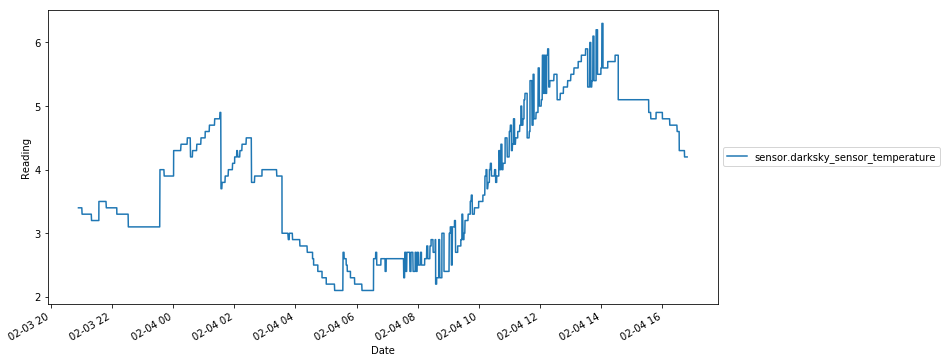

In [11]:
sensors_num.plot('sensor.darksky_sensor_temperature')

Or pass a list of entities to plot:

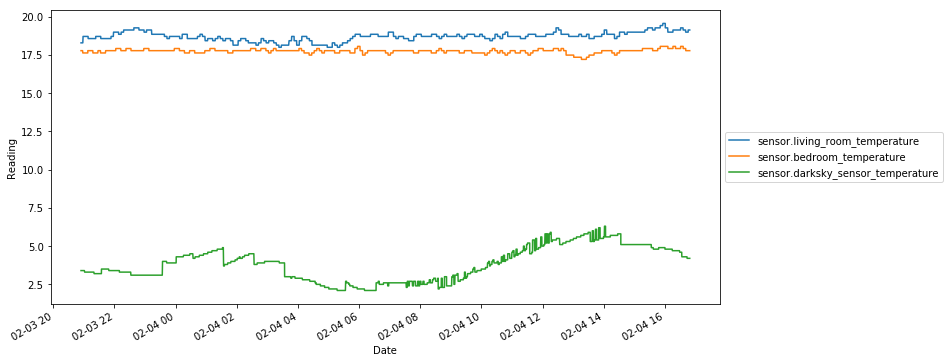

In [12]:
to_plot = ['sensor.living_room_temperature',
           'sensor.bedroom_temperature',
           'sensor.darksky_sensor_temperature']

sensors_num.plot(to_plot)

Even mix up lists and single entites

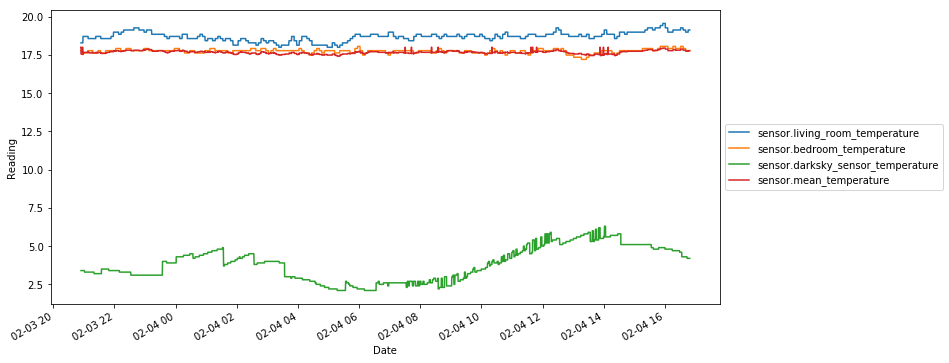

In [13]:
sensors_num.plot(to_plot, 'sensor.mean_temperature')

#### Pairplot
A seaborn pair plot to show correlations.

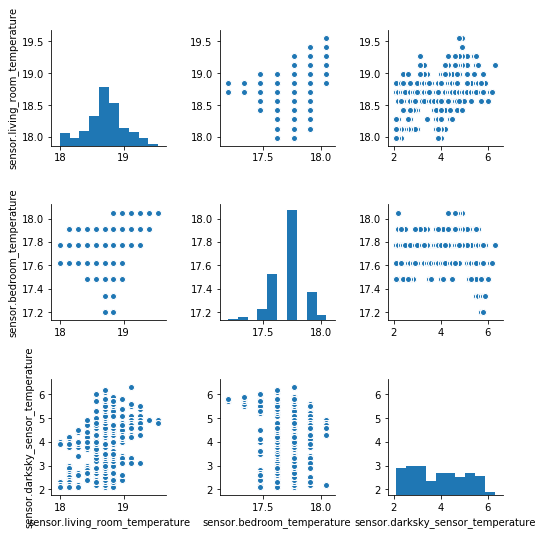

In [14]:
sns.pairplot(sensors_num.data[to_plot]);

## Binary sensors
Class for handling binary sensors with on/off states.

In [15]:
sensors_binary = detective.BinarySensors(parser.master_df)

In [16]:
sensors_binary.entities

['binary_sensor.motion_at_home',
 'binary_sensor.in_bed_bayesian',
 'binary_sensor.elgato_door',
 'binary_sensor.late_night_sensor',
 'binary_sensor.devices_home',
 'binary_sensor.wipy_water_monitor',
 'binary_sensor.fibaro_leak',
 'binary_sensor.macbook',
 'binary_sensor.workday_sensor',
 'binary_sensor.living_room_nest_protect_online',
 'binary_sensor.blink_armed_status',
 'binary_sensor.blink_blink_camera_percy_motion_enabled',
 'binary_sensor.kettle',
 'binary_sensor.doorbell']

Currently we can plot a single binary sensor with the plot() method

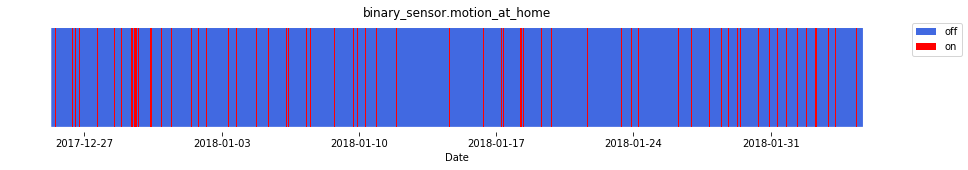

In [17]:
sensors_binary.plot('binary_sensor.motion_at_home')

## Day of week analysis

Lets analyse the **motion_at_home**, create some features for day of week and time category, then analyse motion by these features.

In [18]:
motion_df = sensors_binary.data[['binary_sensor.motion_at_home']] # Must pass a list to return correctly indexed df

In [19]:
motion_df['weekday'] = motion_df.index.weekday_name

In [20]:
motion_df['is_weekday'] = motion_df.index.map(lambda x: helpers.is_weekday(x))

In [21]:
motion_df = motion_df[motion_df['binary_sensor.motion_at_home'] == True] # Keep only true detection events

In [22]:
motion_df['time_category'] = motion_df.index.map(lambda x: helpers.time_category(x))

In [23]:
motion_df.head()

entity,binary_sensor.motion_at_home,weekday,is_weekday,time_category
last_changed,,,,
2017-12-25 07:32:05.284759,True,Monday,True,morning
2017-12-25 07:32:35.294064,True,Monday,True,morning
2017-12-25 07:33:32.286046,True,Monday,True,morning
2017-12-25 07:41:50.294864,True,Monday,True,morning
2017-12-25 07:50:08.284818,True,Monday,True,morning


In [24]:
motion_df['binary_sensor.motion_at_home'].groupby(motion_df['is_weekday']).describe()['count']

is_weekday
False    2891
True     7374
Name: count, dtype: object

In [25]:
motion_df_gb = motion_df['binary_sensor.motion_at_home'].groupby([motion_df['weekday'], motion_df['time_category']]).sum().unstack()
motion_df_gb.fillna(value=0, inplace=True)   # Replace NaN with 0
motion_df_gb = motion_df_gb.astype('int')              # Ints rather than floats
motion_df_gb = motion_df_gb.T
motion_df_gb

weekday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
time_category,,,,,,,
daytime,456,434,599,961,370,605,306
evening,434,476,142,304,473,517,702
morning,507,398,437,370,497,509,498
night,48,14,26,52,58,56,16


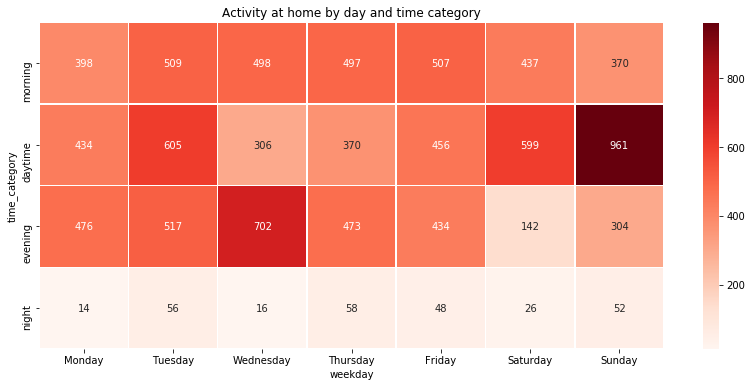

In [26]:
fig, ax = plt.subplots(figsize=(14, 6))
days_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
times_list = ['morning', 'daytime', 'evening', 'night']
ax = sns.heatmap(motion_df_gb[days_list].loc[times_list], annot=True, linewidths=.5, fmt="d", ax=ax, cmap='Reds');
ax.set_title('Activity at home by day and time category')
fig.savefig('heatmap.jpg')

#### Prediction with prophet
Lets do some forecasting using prophet. We require a single sensor which is a pandas data series object.

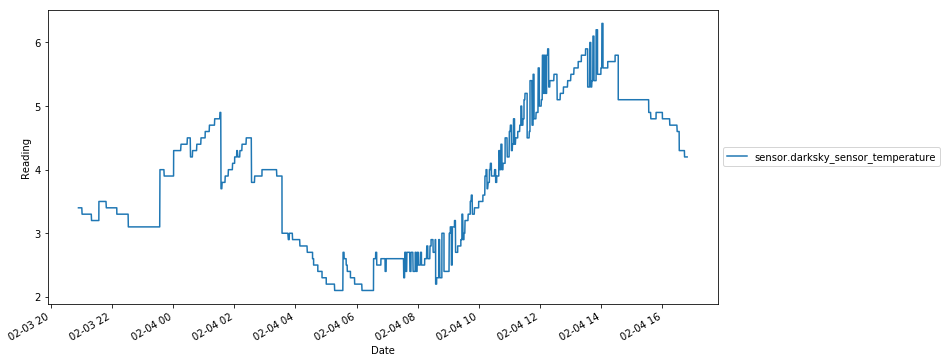

In [27]:
to_plot = 'sensor.darksky_sensor_temperature'
sensors_num.plot(to_plot)

In [28]:
sensors_ds = sensors_num.data[to_plot]

In [29]:
 # retuns a series
pred1 = detective.Prediction(sensors_ds)

Create a prophet model

In [30]:
print(pred1.prophet_model.__doc__)


        Make a propet model for the given sensor for the number of periods.

        Parameters
        ----------

        periods : int
            The default period is 0 (no forecast)

        freq : str
            Unit of time, defaults to seconds.
        


In [31]:
%%time
pred1.prophet_model(periods=5, freq='H')

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


CPU times: user 9.09 s, sys: 227 ms, total: 9.31 s
Wall time: 9.66 s


/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


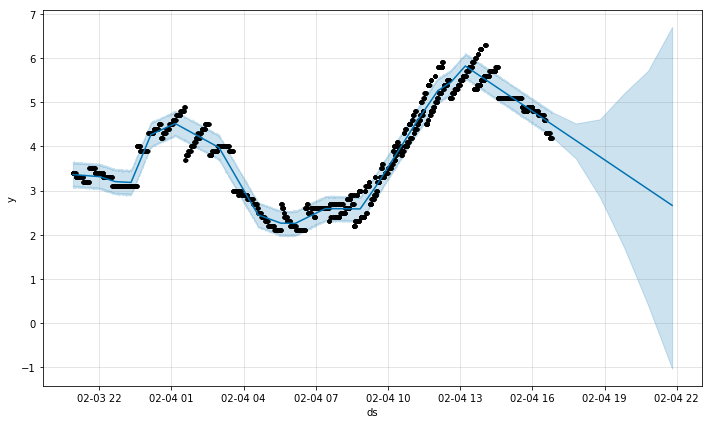

In [32]:
pred1.plot_future()

TypeError: zip argument #1 must support iteration

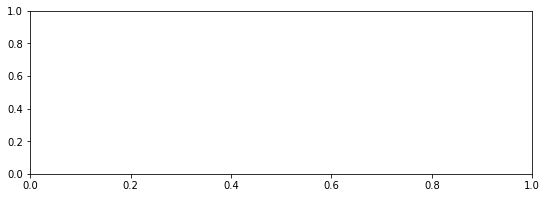

In [33]:
pred1.plot_components()

Clearly the daily trend is for the warmest temperatures at early afternoon